# Overall price 

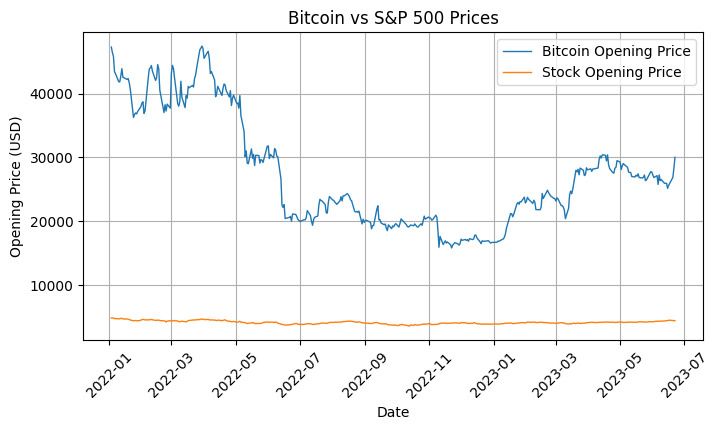

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

prices = pd.read_csv('./Processed/combined_prices.csv')

prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.sort_values('Date')
prices.set_index('Date', inplace=True)


plt.figure(figsize=(8, 4)) 
plt.plot(prices.index, prices['Open_B'], label='Bitcoin Opening Price', linewidth=1)
plt.plot(prices.index, prices['Open_S'], label='Stock Opening Price', linewidth=1)

plt.title('Bitcoin vs S&P 500 Prices')
plt.xlabel('Date')
plt.ylabel('Opening Price (USD)')

plt.xticks(rotation=45)

plt.grid(True)

plt.legend()  
plt.show()

In [200]:
prices.reset_index(inplace=True)
window = 30
neurons = 64
epochs_count = 60
batch = 32


Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1648 - val_loss: 0.0564
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0851 - val_loss: 0.0175
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0312 - val_loss: 0.0035
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0190 - val_loss: 0.0019
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - val_loss: 0.0038
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0023
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0033
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 9/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 10/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0065
Epoch 11/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 12/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 13/60


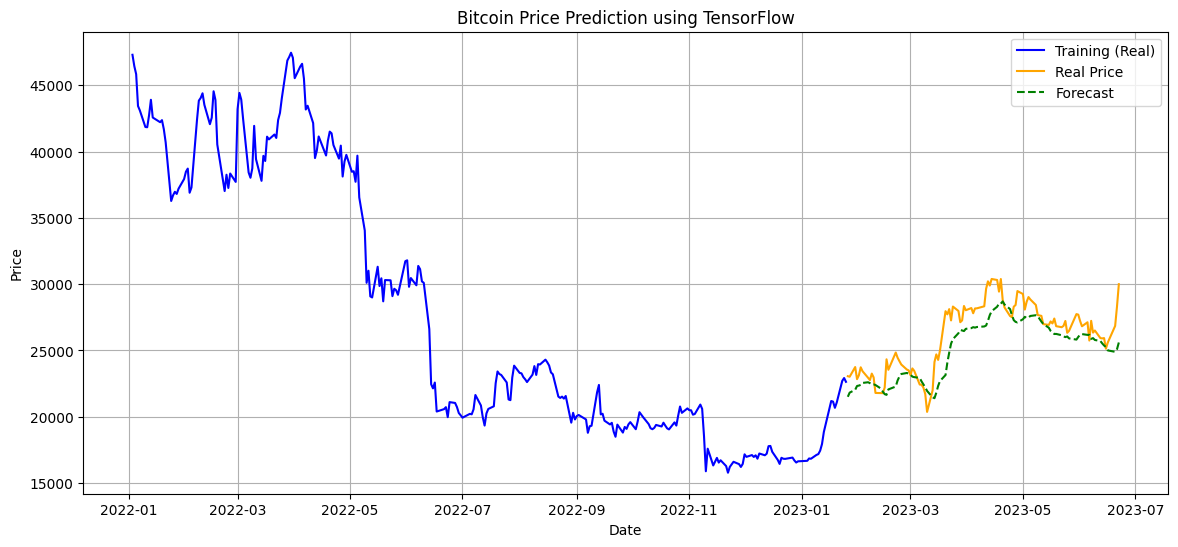

MAE: 1198.69
MSE: 2384460.14
RMSE: 1544.17
R² Score: 0.62


In [201]:
btc_model = prices[['Date', 'Open_B']].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(btc_model[['Open_B']])
btc_model['Scaled'] = scaled

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = window
X, y = create_sequences(btc_model['Scaled'].values, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(neurons, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=epochs_count, batch_size=batch, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(14, 6))
plt.plot(btc_model['Date'].iloc[:len(X_train) + window_size],
         scaler.inverse_transform(btc_model['Scaled'].values[:len(X_train) + window_size].reshape(-1, 1)), 
         label='Training (Real)', color='blue'
         )
plt.plot(btc_model['Date'].iloc[-len(y_test_inv):], y_test_inv.ravel(), label='Real Price', color='orange')
plt.plot(btc_model['Date'].iloc[-len(y_pred_inv):], y_pred_inv.ravel(), label='Forecast', color='green', linestyle='dashed')
plt.title('Bitcoin Price Prediction using TensorFlow')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



In [ ]:
btc_model = prices[['Date', 'Open_B', 'sentiment_label']].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(btc_model[['Open_B', 'sentiment_label']])
btc_model['Scaled_Open_B'] = scaled[:, 0]
btc_model['Scaled_Sentiment'] = scaled[:, 1]

def create_sequences_multivariate(data, col, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, col])
    return np.array(X), np.array(y)

window_size = window
features = btc_model[['Scaled_Open_B', 'Scaled_Sentiment']].values

X, y = create_sequences_multivariate(features, col=0, window=window_size)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = Sequential([
    Input(shape=(window_size, 2)),
    LSTM(neurons, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=epochs_count, batch_size=batch, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)

y_pred_pad = np.concatenate([y_pred, np.zeros((y_pred.shape[0], 1))], axis=1)
y_test_pad = np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))], axis=1)

y_pred_inv = scaler.inverse_transform(y_pred_pad)[:, 0]
y_test_inv = scaler.inverse_transform(y_test_pad)[:, 0]


dates_train = btc_model['Date'].iloc[window_size:len(X_train) + window_size]

train_prices = scaler.inverse_transform(
    btc_model[['Scaled_Open_B', 'Scaled_Sentiment']].values[window_size:len(X_train) + window_size]
)[:, 0]

dates_test = btc_model['Date'].iloc[-len(y_test_inv):]

plt.figure(figsize=(14, 6))
plt.plot(dates_train, train_prices, label='Training (Real)', color='blue')
plt.plot(dates_test, y_test_inv, label='Real Price', color='orange')
plt.plot(dates_test, y_pred_inv, label='Forecast', color='green', linestyle='dashed')
plt.title('Bitcoin Price Prediction using TensorFlow')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0950 - val_loss: 0.0048
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0358 - val_loss: 0.0086
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0152 - val_loss: 0.0090
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0156
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0162
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0104
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0093
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0096
Epoch 9/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0111
Epoch 10/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0106
Epoch 11/60
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3827 - val_loss: 0.3372
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2533 - val_loss: 0.1600
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1109 - val_loss: 0.0465
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0879 - val_loss: 0.0981
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0891 - val_loss: 0.0667
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0741 - val_loss: 0.0426
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0696 - val_loss: 0.0732
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0752 - val_loss: 0.0506
Epoch 9/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0718 - val_loss: 0.0541
Epoch 10/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0683 - val_loss: 0.0522
Epoch 11/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0666 - val_loss: 0.0539
Epoch 12/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0627 - val_loss: 0.0549
Epoch 13/40


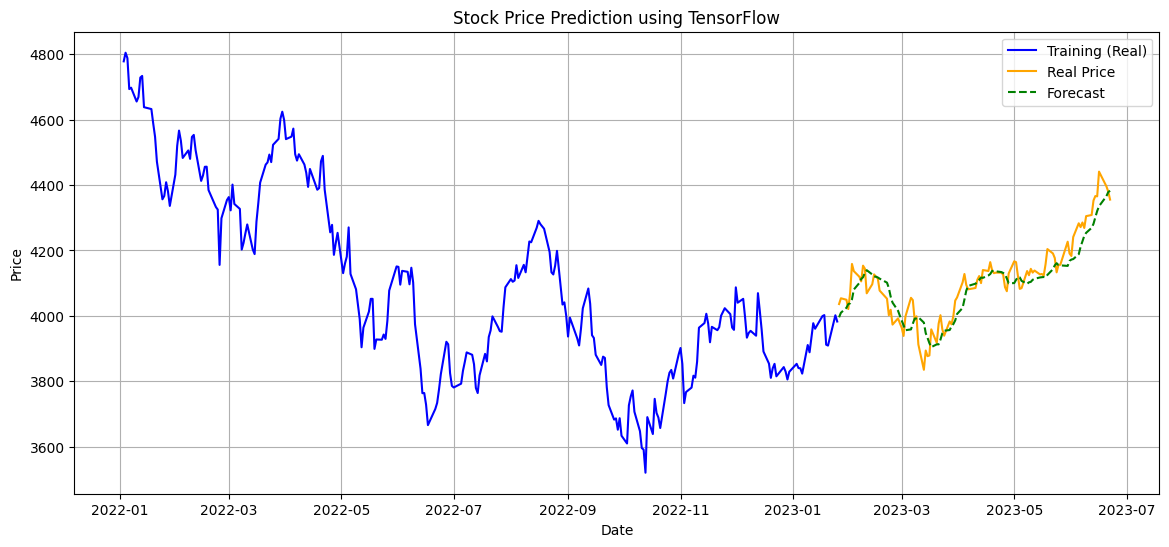

MAE: 36.52
MSE: 2154.24
RMSE: 46.41
R² Score: 0.85


In [197]:
stock_model = prices[['Date', 'Open_S']].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(stock_model[['Open_S']])
stock_model['Scaled'] = scaled

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = window
X, y = create_sequences(stock_model['Scaled'].values, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = Sequential([
    Input(shape=(window_size, 1)), 
    LSTM(neurons, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=epochs_count, batch_size=batch, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(14, 6))
plt.plot(stock_model['Date'].iloc[:len(X_train) + window_size],
         scaler.inverse_transform(stock_model['Scaled'].values[:len(X_train) + window_size].reshape(-1, 1)), 
         label='Training (Real)', color='blue'
         )
plt.plot(stock_model['Date'].iloc[-len(y_test_inv):], y_test_inv.ravel(), label='Real Price', color='orange')
plt.plot(stock_model['Date'].iloc[-len(y_pred_inv):], y_pred_inv.ravel(), label='Forecast', color='green', linestyle='dashed')
plt.title('Stock Price Prediction using TensorFlow')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

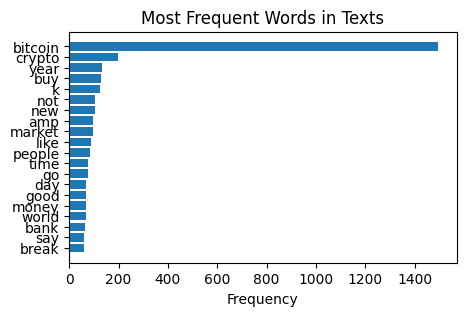

<bound method NDFrame.tail of         token       date  reply_count  like_count  retweet_count  quote_count  \
0     bitcoin 2022-01-01           49         494            133           15   
1     bitcoin 2022-01-01           18         306             30            9   
2     bitcoin 2022-01-01           77         188             28            0   
3     bitcoin 2022-01-02          201        2743            750           22   
4     bitcoin 2022-01-02           99         946            164           10   
...       ...        ...          ...         ...            ...          ...   
1609  bitcoin 2023-06-21           38        1169            141            6   
1610  bitcoin 2023-06-21          184        3056            567           32   
1611  bitcoin 2023-06-22          241        5397           1419           60   
1612  bitcoin 2023-06-22          148        2503            512           13   
1613  bitcoin 2023-06-22          106         347             35            0  

In [198]:
from collections import Counter

visu_words = pd.read_pickle('visu_words.pkl')

word_counter = Counter()

for tokens in visu_words['text']:
    word_counter.update(tokens)

words, counts = zip(*word_counter.most_common(20))

plt.figure(figsize=(5, 3))
plt.barh(words[::-1], counts[::-1])
plt.xlabel('Frequency')
plt.title('Most Frequent Words in Texts')
plt.show()
visu_words.tail
